In [1]:
import IPython.display as disp
import numpy as np
import sympy as sp
import networkx as nx
import networkx.algorithms.isomorphism as iso
import random
import itertools
import matplotlib.pyplot as plt
import timeit
import math

In [2]:
# functions to calculate graph polynomials

# walk count sequence until length n
def generate_walk_count(matrix, n, v=None, w=None):
    if len(matrix.shape) != 2 or matrix.shape[0] != matrix.shape[1]:
        print("not a square matrix")
        return
    if v == None:
        v = sp.ones(matrix.shape[0],1)
    if w == None:
        w = sp.ones(matrix.shape[0],1)
    walk_count = []
    walks = sp.eye(matrix.shape[0])
    # the walk count r equals the sum over all elements in the adjacency matrix to the power r
    walk_count.append((v.T*walks*w)[0,0])
    for i in range(1,n+1):
        walks = walks * matrix
        walk_count.append((v.T*walks*w)[0,0])
    return walk_count

# calculates how many walks the node v produces relative to the total walk count
# importance is equal to the number of walks of length n-1 ending in v multiplied with the degree of v
def relative_importance(g, v, n, part=None, weighted=True):
    if part == None:
        part = [[i] for i in range(g.shape[0])]
    complete_partition(g, part)
    size = g.shape[0]
    g = partition(g, part)
    card = sp.Matrix([len(p) for p in part]).T
    #card = sp.Matrix([1 for p in part]).T
    d = 1
    if weighted:
        d = sum(g[v, :])
    rel_imp = [(d * card[v]) / sum(card)]
    walks = g
    for i in range(n-1):
        imp = sum((card * walks)[:, v]) * d
        rel_imp.append(imp / sum(card * walks))
        walks = walks * g
    return rel_imp

# calculates the minimal polynomial of a graph
def minimal_poly(matrix,x=sp.symbols("x"), v=None, w=None):
    if len(matrix.shape) != 2 or matrix.shape[0] != matrix.shape[1]:
        print("not a square matrix")
        return
    # calculate characteristic poly
    charPoly = matrix.charpoly(x)
    factors = sp.factor_list(charPoly.as_expr())
    minPoly = 1
    # multiply all factors of the characteristic polynomial
    # sp.factor_list only returns irreducible factors without multiplicity
    for i in range(len(factors[1])):
        minPoly *= factors[1][i][0]
    min_resid = residual(matrix, minPoly, v=v, w=w)
    return minPoly.expand(), min_resid

# returns the residual of a sequence relative to the given polynomial
# in other words, the image of the given sequence under the mapping Z^\infty \to Z[x]/(f)
def residual_seq(sequence, poly, x=sp.symbols("x")):
    d = sp.degree(poly)
    if len(sequence) < d:
        print("sequence is too short")
        return
    coeffs = poly.as_poly().all_coeffs()
    res = 0
    for i in range(d):
        coeff = sequence[i]
        for j in range(1,i+1):
            coeff += coeffs[j]*sequence[i-j]
        res += coeff*x**(d-i-1)
    return res

# wrapper around the residual for matrices instead of sequences
def residual(matrix, poly, x = sp.symbols("x"), v=None, w=None):
    walk_count = generate_walk_count(matrix, sp.degree(poly), v=v, w=w)
    return residual_seq(walk_count, poly, x)

# computes the recurrence polynomial of the given graph
# the recurrence polynomial consists of all factors of the characteristic polynomial
# which are not contained in the residual of the graphs walk count relative to its characteristic polynomial
def recurrence_poly(matrix, x=sp.symbols("x"), v=None, w=None):
    char_poly = matrix.charpoly(x).as_expr()
    char_resid = residual(matrix, char_poly, x=x, v=v, w=w)
    if char_resid == 0:
        return x ** 0, 0 * x
    d = sp.degree(char_poly)
    resid_factors = sp.factor_list(char_resid)
    rec_poly = char_poly
    rec_resid = char_resid
    for fac in resid_factors[1]:
        if sp.rem(char_poly, fac[0]) == 0:
            quotient = sp.gcd(char_poly, fac[0]**fac[1])
            rec_poly = sp.quo(rec_poly, quotient)
            rec_resid = sp.quo(rec_resid, quotient)
    return rec_poly, rec_resid

# does what its name says...
# produces latex code
def pretty_poly_print(poly, name=None):
    if name != None:
        prefix = "\\text{" + name + ": }"
    else:
        prefix = ""
    string = prefix + sp.latex(poly.expand())
    if not (poly.is_constant() or poly.as_poly().is_irreducible) or (not poly.is_constant() and sp.factor_list(poly.as_expr())[0] > 1):
        string += " = " + sp.latex(poly.factor())
    disp.display(disp.Math(string))

# displays the characteristic polynomial, minimal polynomial, minimal residual,
# recurrence polynomial, residual relative to recurrence polynomial
# can show roots of the polynomials, can draw the graph
def analyze(matrix,x=sp.symbols("x"), show_graph=True, show_roots=False, draw_method=nx.draw, v=None, w=None):
    if show_graph:
        G = nx.from_numpy_matrix(np.matrix(matrix).astype(int))
        draw_method(G)
    char_poly = matrix.charpoly(x).as_expr()
    char_resid = residual(matrix, char_poly, x=x, v=v, w=w)
    min_poly, min_resid = minimal_poly(matrix, x, v=v, w=w)
    rec_poly, rec_resid = recurrence_poly(matrix, x, v=v, w=w)
    walk_count = generate_walk_count(matrix, sp.degree(min_poly), v=v, w=w)
    walk_count_str = "\\text{walk count sequence: " + str(walk_count[0])
    for i in range(1,len(walk_count)):
        walk_count_str += ", " + str(walk_count[i])
    walk_count_str += "}, \\ldots"
    disp.display(disp.Math(walk_count_str))
    n = matrix.shape[0]
    avg_deg = round(float(1 / n * sum([sum(matrix[i,:]) for i in range(n)])),6)
    disp.display(disp.Math("\\text{average degree: }" + str(avg_deg)))
    pretty_poly_print(char_poly, "characteristic polynomial")
    prefix = "" if v == None and w == None else "local "
    pretty_poly_print(char_resid, prefix + "characteristic residual")
    #pretty_poly_print(min_poly, "minimal polynomial")
    pretty_poly_print(rec_poly, prefix + "recurrence polynomial")
    if show_roots:
        disp.display(disp.Math("\\text{recurrence roots: }"
                               + sp.latex(sp.roots(rec_poly))))
    #prefix = "graph" if v == None and w == None else "local"
    #pretty_poly_print(rec_resid, prefix + " residual")
    if show_roots:
        disp.display(disp.Math("\\text{residual roots: }"
                               + sp.latex(sp.roots(rec_resid))))

#i-th unit vector of length n
def e_(n,i):
    e_i = sp.zeros(n,1)
    e_i[i,0] = 1
    return e_i

def deg(g, i):
    return (e_(g.shape[0],i).T*g*sp.ones(g.shape[0],1))[0,0]
        
def analyze_uv(matrix, u, v, x=sp.symbols("x"), show_graph=True, show_roots=False, draw_method=nx.draw):
    e_u = e_(matrix.shape[0],u)
    e_v = e_(matrix.shape[0],v)
    analyze(matrix, x=x, show_graph=show_graph, show_roots=show_roots, draw_method=draw_method, v=e_u, w=e_v)

In [3]:
# graph sandbox

# empty graph with n vertices
def empty(n):
    if n < 1:
        return
    return sp.zeros(n)

# path
def path(n):
    if n < 2:
        return
    p_n = sp.zeros(n)
    for i in range(n-1):
        p_n[i,i+1] = 1
        p_n[i+1,i] = 1
    return p_n

# circle
# alternatively circulant(n,1)
def circle(n):
    if n < 2:
        return
    p_n = sp.zeros(n)
    for i in range(n):
        p_n[i,(i+1)%n] = 1
        p_n[(i+1)%n,i] = 1
    return p_n

# circulant graph
def circulant(n, neighbors):
    if n < 2:
        return
    cg = sp.zeros(n)
    for i in range(n):
        for j in neighbors:
            cg[i, (i + j) % n] = 1
            cg[(i + j) % n, i] = 1
            cg[i, (i - j) % n] = 1
            cg[(i - j) % n, i] = 1
    return cg

# complete graph
def complete(n):
    if n < 2:
        return
    k_n = sp.ones(n) - sp.eye(n)
    return k_n

# star graph with n nodes
# equivalently gen_star(n-1,1)
def star(n):
    if n < 2:
        return
    s_n = sp.zeros(n)
    for i in range(n-1):
        s_n[i,n-1] = 1
        s_n[n-1,i] = 1
    return s_n

# more general star, each star arm has length k
# graph consists of one center node with n arms of length k
def gen_star(n, k):
    if n < 1 or k < 1:
        return
    m = n * k + 1
    g_nk = sp.zeros(m)
    for i in range(n):
        g_nk[i * k, m - 1] = 1
        g_nk[m - 1, i * k] = 1
        for j in range(1, k):
            g_nk[i * k + j, i * k + j - 1] = 1
            g_nk[i * k + j - 1, i * k + j] = 1
    return g_nk

# a customized star graph where the length of each arm is given explicitely
def custom_star(arm_lengths):
    arm_lengths = [l for l in arm_lengths if l > 0]
    n = sum(arm_lengths) + 1
    csg = sp.zeros(n)
    start = 0
    for l in arm_lengths:
        csg[n - 1, start] = 1
        csg[start, n - 1] = 1
        for i in range(l - 1):
            csg[start + i, start + i + 1] = 1
            csg[start + i + 1, start + i] = 1
        start += l
    return csg

# wheel with n nodes
# a star graph where the outer vertices are connected toa cycle
def wheel(n):
    if n < 2:
        return
    w_n = star(n)
    for i in range(n-1):
        w_n[i, (i + 1) % (n - 1)] = 1
        w_n[(i + 1) % (n - 1), i] = 1
    return w_n

# grid with n * m nodes
# could be product(path(n),path(m))
def grid(n,m):
    if n < 2 or m < 2: # else use a path...
        return
    g_nm = sp.zeros(n*m)
    for i in range(n):
        for j in range(m):
            if i < n-1:
                g_nm[j * n + i, j * n + i + 1] = 1
                g_nm[j * n + i + 1, j * n + i] = 1
            if j < m-1:
                g_nm[j * n + i, (j + 1) * n + i] = 1
                g_nm[(j + 1) * n + i, j * n + i] = 1
    return g_nm

# complete bipartite graph
def complete_bipartite(n, m):
    bg = sp.zeros(n + m)
    for i in range (n):
        for j in range(m):
            bg[i, n + j] = 1
            bg[n + j, i] = 1
    return bg

# complete binary trees of height h
def complete_binary_tree(h):
    n = 2**h - 1
    cb = sp.zeros(n)
    for i in range(h - 1):
        for j in range(2**i):
            current_node = 2**i + j
            cb[current_node - 1, 2 * current_node - 1] = 1
            cb[2 * current_node - 1, current_node - 1] = 1
            cb[current_node - 1, 2 * current_node] = 1
            cb[2 * current_node, current_node - 1] = 1
    return cb

# hypercube of dimension d
def hypercube(d):
    hc = empty(1)
    while d > 0:
        hc = product(hc, path(2))
        d -= 1
    return hc

# a graph with 6n nodes that has exactly the cyclic group Z/n as automorphisms for n > 1
def cyclic_group_graph(n):
    if n < 2:
        return
    cg_n = sp.zeros(6 * n)
    for i in range(n):
        node = 6 * i
        cg_n[node, node + 1] = 1
        cg_n[node + 1, node] = 1
        cg_n[node + 1, node + 2] = 1
        cg_n[node + 2, node + 1] = 1
        cg_n[node + 1, node + 3] = 1
        cg_n[node + 3, node + 1] = 1
        cg_n[node + 3, node + 4] = 1
        cg_n[node + 4, node + 3] = 1
        cg_n[node + 4, node + 5] = 1
        cg_n[node + 5, node + 4] = 1
        cg_n[node + 3, (node + 6) % (6 * n)] = 1
        cg_n[(node + 6) % (6 * n), node + 3] = 1
    return cg_n

# smallest graph with automorphism group Z/3
def smallest_cyclic_group_graph():
    return sp.Matrix([
        [0,1,1,1,0,0,1,0,1],
        [1,0,1,0,0,0,0,0,0],
        [1,1,0,1,0,0,0,0,0],
        [1,0,1,0,1,1,1,0,0],
        [0,0,0,1,0,1,0,0,0],
        [0,0,0,1,1,0,1,0,0],
        [1,0,0,1,0,1,0,1,1],
        [0,0,0,0,0,0,1,0,1],
        [1,0,0,0,0,0,1,1,0]
    ])
    

# disjoint union of two graphs
def union(g1, g2):
    n1 = sp.shape(g1)[0]
    n2 = sp.shape(g2)[0]
    n = n1 + n2
    du = sp.zeros(n)
    for i in range(n1):
        for j in range(n1):
            du[i,j] = g1[i,j]
    for i in range(n2):
        for j in range(n2):
            du[n1 + i, n1 + j] = g2[i,j]
    return du

# cartesian product of two graphs
def product(g1, g2):
    n1 = sp.shape(g1)[0]
    n2 = sp.shape(g2)[0]
    n = n1 * n2
    cp = sp.zeros(n)
    for i in range(n1):
        for j in range(n2):
            for k in range(i + 1, n1):
                if g1[i,k] == 1:
                    cp[j * n1 + i, j * n1 + k] = 1
                    cp[j * n1 + k, j * n1 + i] = 1
            for k in range(j + 1, n2):
                if g2[j,k] == 1:
                    cp[j * n1 + i, k * n1 + i] = 1
                    cp[k * n1 + i, j * n1 + i] = 1
    return cp

# collapse two vertices of one graph
def collapse(g, v1, v2):
    if v1 == v2:
        return
    if v1 > v2:
        tmp = v1
        v1 = v2
        v2 = tmp
    n = sp.shape(g)[0]
    jg = sp.zeros(n - 1)
    for i in range (n - 1):
        if i == v1: continue
        real_i = i if i < v2 else i + 1
        for j in range (i + 1, n - 1):
            if j == v1:
                continue
            real_j = j if j < v2 else j + 1
            jg[i, j] = g[real_i, real_j]
            jg[j, i] = g[real_i, real_j]
        if (g[real_i, v1] == 1 or g[real_i, v2] == 1):
            jg[i, v1] = 1
            jg[v1, i] = 1
    return jg

# more convenient collapse: collapse a list of tuples
def collapse_list(g, join_nodes):
    join_nodes = [tuple(sorted(t)) for t in join_nodes] # sort every single tuple ascending
    join_nodes.sort(key = lambda t : -t[1]) # sort descending by second join node
    for i in range (1, len(join_nodes)):
        if join_nodes[i][1] == join_nodes[i - 1][1]:
            join_nodes[i][1] = join_nodes[i - 1][0]
    join_nodes.sort(key = lambda t : -t[1])
    for t in join_nodes:
        g = collapse(g, t[0], t[1])
    return g

# join two graphs
# connect each vertex of g1 with each vertex of g2
def join(g1, g2):
    g = union(g1, g2)
    n1 = g1.shape[0]
    n2 = g2.shape[0]
    for i in range (n1):
        for j in range (n1, n1 + n2):
            g[i, j] = 1
            g[j, i] = 1
    return g

# graph with a cut edge
# i.e. disjoint union of g1 and g2 adding an edge from u in g1 to v in g2
def cut_edge(g1, g2, u, v):
    g = union(g1, g2)
    n1 = g1.shape[0]
    g[u, n1 + v] = 1
    g[n1 + v, u] = 1
    return g

# repeat a graph n times by transitively joining the vertices v1 of the next graph with v2 of the previous graph
def repeat(g, n, v1, v2):
    rg = g
    m = sp.shape(g)[0]
    for i in range (n - 1):
        rg = union(rg, g)
    join_nodes = [(v2 + i * m, v1 + ((i + 1) * m % (n * m))) for i in range (n)]
    rg = collapse_list(rg, join_nodes)
    return rg

# complement of a graph
def complement(g):
    n = g.shape[0]
    c = sp.zeros(n)
    for i in range (n):
        for j in range(i + 1, n):
            c[i, j] = 1 - g[i, j]
            c[j, i] = 1 - g[j, i]
    return c

# complement which complements also self-loops
def full_complement(g):
    n = g.shape[0]
    return sp.ones(n) - g

# tensor product oft two graphs, similar to usual product
def tensor_product(g1, g2):
    n1 = g1.shape[0]
    n2 = g2.shape[0]
    n = n1 * n2
    g = sp.zeros(n)
    for i in range(n1):
        for j in range(n2):
            for k in range(n1):
                for l in range(n2):
                    if g1[i, k] * g2[j, l] == 1:
                        g[j * n1 + i, l * n1 + k] = 1
                        g[l * n1 + k, j * n1 + i] = 1
    return g

# double cover of a graph
def double_cover(g):
    return tensor_product(g, path(2))

def complete_partition(g, part):
    n = g.shape[0]
    if len(part) == 0:
        return [[i] for i in range(n)]
    part = [set(l) for l in part if len(l) > 0]
    if max([max(l) for l in part]) >= n or min([min(l) for l in part]) < 0:
        return
    for i in range(len(part)):
        for j in range(i + 1, len(part)):
            if len(part[i].intersection(part[j])) > 0:
                return
    
    part_numbers = set.union(*part)
    non_part_numbers = [[i] for i in range(n) if i not in part_numbers]
    return part + non_part_numbers

# computes the given equitable partition of the graph
def partition(g, part):
    complete_part = complete_partition(g, part)
    n_p = len(complete_part)
    g_p = sp.zeros(n_p)
    
    for (i, j) in itertools.product(range(n_p),range(n_p)):
        p1 = complete_part[i]
        p2 = complete_part[j]
        edges = [sum([g[v, w] for w in p2]) for v in p1]
        if len(set(edges)) > 1:
            return
        g_p[i, j] = edges[0]
    return g_p

# coarsest equitable partition
def coarsest_partition(g):
    n = g.shape[0]
    parts = [list(range(n))]
    changed = True
    deg_vects = sp.zeros(n, len(parts))
    while changed:
        changed = False
        deg_vects = sp.zeros(n, len(parts))
        new_parts = []
        for i in range(len(parts)):
            for k in parts[i]:
                for j in range(len(parts)):
                    for l in parts[j]:
                        deg_vects[k, j] += g[k, l]
        
        for i in range(len(parts)):
            while len(parts[i]) > 0:
                new_part = [parts[i][j] 
                            for j in range(len(parts[i])) 
                            if deg_vects.row(parts[i][j]) == deg_vects.row(parts[i][0])]
                if len(new_part) < len(parts[i]):
                    changed = True
                new_parts.append(new_part.copy())
                new_part.sort(key = lambda x: -x)
                for j in new_part:
                    parts[i].remove(j)
        parts = new_parts
    return parts

#resolves simple loops by copying the graph and connecting all vertices with self loops
def resolve_simple_loops(g):
    n = g.shape[0]
    g_res = sp.zeros(2 * n)
    for i in range(n):
        for j in range(i + 1, n):
            g_res[i, j] = g[i, j]
            g_res[j, i] = g[j, i]
            g_res[n + i, n + j] = g[i, j]
            g_res[n + j, n + i] = g[j, i]
        g_res[i, n + i] = g[i, i]
        g_res[n + i, i] = g[i, i]
    return g_res

# intersection of two partitions (not equitable in general!)
def partition_intersect(part1, part2):
    part = []
    for p1 in part1:
        for p2 in part2:
            p = list(set(p1).intersection(set(p2)))
            if len(p) > 0:
                part.append(p)
    return part

# union of two partitions (equitable?)
def partition_union(part1, part2):
    part = part1 + part2
    changed = True
    while changed:
        changed = False
        for i in range(len(part)):
            for j in range(i + 1, len(part)):
                if (len(set(part[i]).intersection(part[j])) > 0):
                    part[i] = list(set(part[i]).union(part[j]))
                    del part[j]
                    changed = True
                    break
            if changed:
                break
    return part
            
def partition_geq(g, p1, p2):
    n = g.shape[0]
    complete_p1 = complete_partition(g, p1)
    complete_p2 = complete_partition(g, p2)
    for part2 in p2:
        for part1 in p1:
            intersect_num = len(set(part1).intersection(set(part2)))
            if not intersect_num in [0, len(part2)]:
                return False
    return True
    
def partition_cmp(g, p1, p2):
    cmp1 = partition_geq(g, p1, p2)
    cmp2 = partition_geq(g, p2, p1)
    if cmp1 and cmp2:
        return 0
    elif cmp1:
        return 1
    elif cmp2:
        return -1
    else:
        return None

def remove_isolated(g):
    g2 = g.copy()
    done = False
    while not done:
        done = True
        for i in range(g2.shape[0]):
            if sum(g2[i,:]) == 0:
                g2.row_del(i)
                g2.col_del(i)
                done = False
                break
    return g2

def remove_node(g, node):
    g2 = g.copy()
    g2.row_del(node)
    g2.col_del(node)
    return g2

def remove_nodes(g, nodes):
    g2 = g.copy()
    nodes.sort(key=lambda x: -x)
    for node in nodes:
        g2 = remove_node(g2, node)
    return g2

def add_edge(g, u, v):
    g2 = g.copy()
    g2[u,v] = 1
    g2[v,u] = 1
    return g2

# frucht graph
def frucht():
    return sp.Matrix([[0,1,1,0,0,0,0,0,0,0,0,1],
                      [1,0,1,0,0,0,0,0,0,1,0,0],
                      [1,1,0,1,0,0,0,0,0,0,0,0],
                      [0,0,1,0,1,1,0,0,0,0,0,0],
                      [0,0,0,1,0,1,0,0,0,0,0,1],
                      [0,0,0,1,1,0,1,0,0,0,0,0],
                      [0,0,0,0,0,1,0,1,1,0,0,0],
                      [0,0,0,0,0,0,1,0,1,0,1,0],
                      [0,0,0,0,0,0,1,1,0,1,0,0],
                      [0,1,0,0,0,0,0,0,1,0,1,0],
                      [0,0,0,0,0,0,0,1,0,1,0,1],
                      [1,0,0,0,1,0,0,0,0,0,1,0]])

# petersen graph
def petersen():
    return sp.Matrix([[0,1,0,0,1,1,0,0,0,0],
                      [1,0,1,0,0,0,1,0,0,0],
                      [0,1,0,1,0,0,0,1,0,0],
                      [0,0,1,0,1,0,0,0,1,0],
                      [1,0,0,1,0,0,0,0,0,1],
                      [1,0,0,0,0,0,0,1,1,0],
                      [0,1,0,0,0,0,0,0,1,1],
                      [0,0,1,0,0,1,0,0,0,1],
                      [0,0,0,1,0,1,1,0,0,0],
                      [0,0,0,0,1,0,1,1,0,0]])

# mckay graph, graph with orbits \neq equitable partition
def mckay():
    return cut_edge(cut_edge(complete(3),path(2),0,0),complete(3),4,0)

# random graph with n vertices
def random_graph(n, density = 0.5):
    if n < 2:
        return
    rg = sp.zeros(n)
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < density:
                rg[i,j] = 1
                rg[j,i] = 1
    return rg

In [4]:
# Knuth algorithm to list all m-partitions of list ns
# not my implementation

def algorithm_u(ns, m):
    def visit(n, a):
        ps = [[] for i in range(m)]
        for j in range(n):
            ps[a[j + 1]].append(ns[j])
        return ps

    def f(mu, nu, sigma, n, a):
        if mu == 2:
            yield visit(n, a)
        else:
            for v in f(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v
        if nu == mu + 1:
            a[mu] = mu - 1
            yield visit(n, a)
            while a[nu] > 0:
                a[nu] = a[nu] - 1
                yield visit(n, a)
        elif nu > mu + 1:
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = mu - 1
            else:
                a[mu] = mu - 1
            if (a[nu] + sigma) % 2 == 1:
                for v in b(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            while a[nu] > 0:
                a[nu] = a[nu] - 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v

    def b(mu, nu, sigma, n, a):
        if nu == mu + 1:
            while a[nu] < mu - 1:
                yield visit(n, a)
                a[nu] = a[nu] + 1
            yield visit(n, a)
            a[mu] = 0
        elif nu > mu + 1:
            if (a[nu] + sigma) % 2 == 1:
                for v in f(mu, nu - 1, 0, n, a):
                    yield v
            else:
                for v in b(mu
                           , nu - 1, 0, n, a):
                    yield v
            while a[nu] < mu - 1:
                a[nu] = a[nu] + 1
                if (a[nu] + sigma) % 2 == 1:
                    for v in f(mu, nu - 1, 0, n, a):
                        yield v
                else:
                    for v in b(mu, nu - 1, 0, n, a):
                        yield v
            if (mu + sigma) % 2 == 1:
                a[nu - 1] = 0
            else:
                a[mu] = 0
        if mu == 2:
            yield visit(n, a)
        else:
            for v in b(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                yield v

    n = len(ns)
    a = [0] * (n + 1)
    for j in range(1, m + 1):
        a[n - m + j] = j - 1
    return f(m, n, 0, n, a)

In [5]:
def equitable_partitions(g, k):
    n = g.shape[0]
    if k == 1:
        partitions = [[list(range(n))]]
    else:
        partitions = list(algorithm_u(list(range(n)), k))
    for part in partitions:
        g_div = partition(g, part)
        if not g_div == None:
            yield part

def equitable_partitions_iso(g, k):
    partitions = list(equitable_partitions(g, k))
    em = iso.numerical_edge_match("weight", 1)
    while len(partitions) > 0:
        iso_class = [partitions[0]]
        delete_idx = [0]
        a1 = np.array(partition(g, partitions[0])).astype(int)
        g1 = nx.from_numpy_array(a1, create_using=nx.DiGraph)
        for i in range(1, len(partitions)):
            part = partitions[i]
            a2 = np.array(partition(g, part)).astype(int)
            g2 = nx.from_numpy_array(a2, create_using=nx.DiGraph)
            if nx.is_isomorphic(g1,g2, edge_match=em):
                iso_class.append(part)
                delete_idx.append(i)
        yield iso_class
        delete_idx.reverse()
        for i in delete_idx:
            del partitions[i]
    
def all_equitable_partitions(g):
    n = g.shape[0]
    min_k = len(coarsest_partition(g))
    for k in range(min_k, n + 1):
        for part in equitable_partitions(g, k):
            yield part
    
def all_equitable_partitions_iso(g):
    n = g.shape[0]
    min_k = len(coarsest_partition(g))
    for k in range(min_k, n + 1):
        for part in equitable_partitions_iso(g, k):
            yield part
    

In [6]:
def partitions_from_eigenvect(v):
    for w in v[2]:
        part = []
        for i in range(len(w)):
            found = False
            for j in range(len(part)):
                #if (abs(w[i]) == abs(w[part[j][0]])):
                if (w[i] == w[part[j][0]]):
                    found = True
                    part[j].append(i)
                    break
            if not found:
                part.append([i])
        yield part


#g = custom_star([2,2,2])

all_eigenvects = g.eigenvects()
all_eigenvects.sort(key = lambda x : sp.re(x[0].evalf()))
non_main_eigenvects = [v for v in all_eigenvects if len([w for w in v[2] if sum(w) != 0]) == 0]
main_eigenvects = [v for v in all_eigenvects[:-1] if len([w for w in v[2] if sum(w) != 0]) != 0]
print("nonmain:")
print(non_main_eigenvects)
print("main:")
print(main_eigenvects)
print("largest:")
print(all_eigenvects[-1])
partitions_nonmain = []
partitions_main = []
partition_largest = []

for v in non_main_eigenvects:
    for part in partitions_from_eigenvect(v):
        partitions_nonmain.append(part)

for v in main_eigenvects:
    for part in partitions_from_eigenvect(v):
        partitions_main.append(part)

for part in partitions_from_eigenvect(all_eigenvects[-1]):
    partition_largest.append(part)

print()
#print("nonmain:", partitions_nonmain)
print("main:", partitions_main)
print("largest:", partition_largest)

#analyze(partition(g, partitions_largest[0]))

NameError: name 'g' is not defined

In [7]:
def apply_rho(g, showKernel=False):
    n = g.shape[0]
    x = sp.symbols("x")
    rho_g = recurrence_poly(g,x)[0]
    c = rho_g.subs(x,0)
    rho_g = rho_g - c
    mat = rho_g.subs(x, g) + c * sp.eye(n)
    display(mat)
    if showKernel:
        print("kernel basis:")
        ns = mat.nullspace()
        for v in ns:
            display(v)
        
def card_matrix(g):
    n = g.shape[0]
    mat = sp.eye(n)
    v = 0
    stack = [v]
    visited = [False] * n
    parents = [-1] * n
    while len(stack) > 0:
        curr_node = stack.pop()
        if visited[curr_node]:
            continue
        visited[curr_node] = True
        p = curr_node
        fac = 1
        while parents[p] != -1:
            fac *= g[parents[p], p] / g[p, parents[p]]
            p = parents[p]
        mat[v, curr_node] = fac
        for i in range(n):
            if (not visited[i]) and (g[curr_node, i] != 0):
                parents[i] = curr_node
                stack.append(i)
    for v in range(1, n):
        mat[v,:] = 1 / mat[0, v] * mat[0, :]
    return mat

def partition_matrix(g, part):
    part = complete_partition(g, part)
    n = g.shape[0]
    k = len(part)
    p_mat = sp.zeros(n, k)
    for i in range(k):
        for v in part[i]:
            p_mat[v, i] = 1
    return p_mat
        

#g = complete_binary_tree(3)
#apply_rho(partition(g, coarsest_partition(g)))
apply_rho(g)

NameError: name 'g' is not defined

In [8]:
def discrete_base_alt(mat, bound=10):
    n, k = mat.shape
    base = sp.zeros(n, k)
    for i in range(3, n):
        for j in range(k):
            nom = mat[i - 2, j] - mat[i - 1, j]
            if nom == 0:
                base[i, j] = mat[i, j] - mat[i - 1, j]
            else:
                if abs(mat[i, j] - mat[i - 1, j]) > abs(bound * nom):
                    val = -bound if (mat[i, j] - mat[i - 1, j]) * nom < 0 else bound
                else:
                    val = (mat[i, j] - mat[i - 1, j]) / nom
                base[i, j] = val
    return base

def plot_sp_mat(mat, size=(12,8)):
    fig, ax = plt.subplots(figsize=size)
    lines = ax.plot(mat)
    ax.legend(iter(lines), list(range(mat.shape[1])))
    plt.show()
    
def show_discrete_bases(mat, n, show_values=True, bound=10, precision=10):
    bases = [mat]
    if show_values:
        print(f"----------------------------------------base0----------------------------------------")
        display(bases[-1].evalf(precision))
    for i in range(n):
        bases.append(discrete_base_alt(bases[-1], bound=bound))
        if show_values:
            print(f"----------------------------------------base{i+1}----------------------------------------")
            display(bases[-1].evalf(precision))
    for i in range(n+1):
        print(f"----------------------------------------base{i}----------------------------------------")
        plot_sp_mat(bases[i])
    return bases

def kernel_dims(g, part=None, weighted=False, show_kernels=False):
    if part == None:
        part = [[i] for i in range(g.shape[0])]
    dims = []
    for i in range(1, len(part)+1):
        mat = sp.Matrix([relative_importance(g, v, i, part, weighted=weighted) for v in range(n_parts)]).T
        if show_kernels:
            display(mat.nullspace())
        dims.append(len(mat.nullspace()))
    return dims
        
n = 500

gcs = g
weighted=False
part = coarsest_partition(gcs)
part = [[i] for i in range(gcs.shape[0])]
n_parts = len(part)
mat = sp.Matrix([relative_importance(gcs, v, n, part, weighted=weighted) for v in range(n_parts)]).T
ker = mat.nullspace()
display(ker)
partition_ = sp.Matrix([[v[i,0] for i in range(v.shape[0])] for v in ker]).nullspace()
partition_ = sp.Matrix([[v[i,0] for i in range(v.shape[0])] for v in partition_])
display(partition_)
display(kernel_dims(gcs, part=part, weighted=weighted))

bases = show_discrete_bases(mat, 3, show_values=False)


NameError: name 'g' is not defined

In [9]:
bases[0][-1,:].evalf(30)

NameError: name 'bases' is not defined

In [10]:
largest_eigvec = sp.re(g.eigenvects()[-1][2][0].evalf(25))
largest_eigvec /= sum(largest_eigvec)
largest_eigenval = sp.re(g.eigenvects()[-1][0].evalf(25))
largest_eigvec

NameError: name 'g' is not defined

In [11]:
largest_eigvec.T.nullspace()

NameError: name 'largest_eigvec' is not defined

In [12]:
def inv_subspace_poly(A, v=None, x=sp.symbols("x")):
    if v == None:
        v = sp.Matrix([1]*g.shape[0])
    n = A.shape[0]
    subspace = v
    for i in range(n):
        kernel = subspace.nullspace()
        if len(kernel) > 0:
            ker = list(kernel[0])
            p = 0
            for j in range(len(ker)-1, -1, -1):
                c = ker[-1-j]
                p += c / ker[0] * x**j
            return p
        v = A * v
        subspace = subspace.col_insert(0,v)
    return g.charpoly(x).as_expr()

def recurrence_degree(A):
    A = np.array(A)
    n = np.shape(A)[0]
    k = n
    v = np.ones(n, dtype=object)
    B = np.eye(n, dtype=object)
    
    while k > 0:
        w = np.zeros(k, dtype=object)
        non_zero = -1
        for i in range(k):
            w_i = B[i].dot(v)
            if w_i != 0:
                if non_zero == -1:
                    non_zero = i
                w[i] = w_i
        #print(B, v, w)
        if non_zero == -1:
            #print(B)
            return n - k
        v_nz = np.array(B[non_zero], dtype=object)
        for i in range(k-1):
            real_i = i
            if i >= non_zero:
                real_i += 1
            #gcd = sp.igcd(w[non_zero], w[real_i])
            #B[i] = w[non_zero] // gcd * B[real_i] - w[real_i] // gcd * v_nz
            B[i] = B[real_i] - w[real_i] / w[non_zero] * v_nz
        k -= 1
        v = A.dot(v)
        B = B[:-1]
    return n

In [13]:
def delta_rec(g, ind, v=None):
    if v == None:
        v = sp.ones(g.shape[0],1)
    if len(ind) == 1:
        return int((v.T*(g**ind[0])*v)[0,0])
    ind = np.array(ind).astype(np.int32)
    for i in range(len(ind)-1):
        if ind[i] + 1 == ind[i+1]:
            return 0
    k=ind[-1]
    ind = ind[:-1]
    res = 0
    for i in range(2**len(ind)):
        index = np.array(list(np.binary_repr(i).zfill(len(ind)))).astype(np.int32)
        l = np.sum(index)
        #print(l,ind,index)
        res += (-1)**l * delta(g,[k-l])*delta(g,ind+index)
    return res
    
def delta(g, ind, already_computed = None):
    if already_computed == None:
        already_computed = {}
    if tuple(ind) in already_computed:
        return already_computed[tuple(ind)]
    if len(ind) == 1:
        v = sp.ones(g.shape[0],1)
        v_i = int((v.T*(g**ind[0])*v)[0,0])
        already_computed[tuple(ind)] = v_i
        return v_i
    ind = np.array(ind, dtype=object)
    for i in range(len(ind)-1):
        if ind[i] + 1 == ind[i+1]:
            return 0
    k=ind[-1]
    ind = ind[:-1]
    res = 0
    for i in range(2**len(ind)):
        index = np.array(list(np.binary_repr(i).zfill(len(ind)))).astype(np.int32).astype(object)
        l = np.sum(index)
        #print(l,ind,index)
        res += (-1)**l * delta(g,[k-l],already_computed=already_computed) // 2 * delta(g,ind+index,already_computed=already_computed)
    already_computed[tuple(np.append(ind,k))] = res
    return res

def delta_indices(k):
    ind = [2*i for i in range(k)]
    for i in range(k-1, -1, -1):
        yield ind.copy()
        ind[i] += 1
    yield ind.copy()
        
def delta_coeffs(g, k, already_computed=None):
    if already_computed == None:
        already_computed = {}
    for ind in delta_indices(k):
        yield (-1)**sum(ind) * delta(g, ind, already_computed=already_computed)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

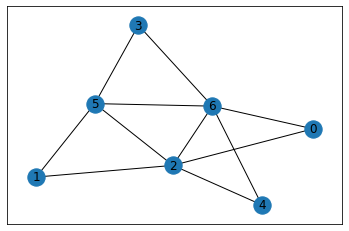

In [14]:
n=7
g = remove_isolated(random_graph(n,0.6))
#g = union(circle(4),circle(3))
x=sp.symbols("x")
cp = g.charpoly(x=x).as_expr()
residuals = sp.Matrix([[residual(g, cp, x=x, v=e_(g.shape[0],i), w=e_(g.shape[0],j)).factor() for i in range(g.shape[0])] for j in range(g.shape[0])])
residuals_expand = sp.Matrix([[residual(g, cp, x=x, v=e_(g.shape[0],i), w=e_(g.shape[0],j)).expand() for i in range(g.shape[0])] for j in range(g.shape[0])])
analyze(g, draw_method=nx.draw_networkx)

In [22]:
(-1)**(n+1)*cp - complement(g).charpoly(x).as_expr().subs(x,-1-x).expand()

2*x**7 + 7*x**6 - 15*x**4 + 11*x**2 - 4*x

In [53]:
nodes1 = sp.ones(n,1)
nodes2 = g**n*nodes1
res = 0*x**0
for i in range(n):
    for j in range(n):
        res += nodes1[i] * nodes2[j] * residuals[i,j]
display(res.expand())

196898*x**6 + 851828*x**5 + 731690*x**4 - 772622*x**3 - 782828*x**2 + 157582*x + 91028

In [55]:
g**n

Matrix([
[3272, 3511, 3529, 3646, 4295, 3477, 4126],
[3511, 3272, 3529, 3477, 4126, 3646, 4295],
[3529, 3529, 3616, 3669, 4390, 3669, 4390],
[3646, 3477, 3669, 3656, 4368, 3776, 4487],
[4295, 4126, 4390, 4368, 5166, 4487, 5286],
[3477, 3646, 3669, 3776, 4487, 3656, 4368],
[4126, 4295, 4390, 4487, 5286, 4368, 5166]])

In [23]:
sp.div(x**n * cp.diff(), cp)[1]

27804*x**6 + 124006*x**5 + 110706*x**4 - 112440*x**3 - 117338*x**2 + 23214*x + 13596

In [41]:
coarsest_partition(g)

[[0, 1], [2], [3, 5], [4, 6]]

In [15]:
def row_poly(cmat, row):
    poly = 0*x**0
    for i in range(cmat.shape[1]):
        poly += x**i * cmat[row, i]
    return poly

cpmat = sp.zeros(g.shape[0],g.shape[0])
for k in range(1, g.shape[0] + 1):
    for i in range(k):
        if i < g.shape[0]:
            cpmat[k - 1, k - 1 - i] = cp.coeff(x**(g.shape[0] - i))
        else:
            cpmat[k - 1, k - 1 - i] = xp.subs(x, 0)

coeff_mat = cpmat
mat = sp.zeros(g.shape[0],g.shape[0])
for k in range(g.shape[0]):
    poly = row_poly(coeff_mat, k)
    q,r = sp.div(poly*cp.diff(),cp)
    for j in range(g.shape[0]-1):
        mat[k, j] = r.coeff(x**(g.shape[0]-1-j))
    mat[k, g.shape[0]-1] = r.subs(x,0)
    pretty_poly_print(r)
display(mat)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrix([
[  7,    0,  -75,  -96,   21,   56,    9],
[  0,   30,   72,  -28, -140,  -54,   14],
[-75,   72, 1097, 1300, -369, -826, -135],
[-96,  -28, 1300, 2460,  770, -804, -366],
[ 21, -140, -369,  770, 2031,  890, -129],
[ 56,  -54, -826, -804,  890, 1250,  294],
[  9,   14, -135, -366, -129,  294,  193]])

In [46]:
def apply_poly(poly, pmat):
    constant = poly.subs(x,0)
    if poly - constant != 0:
        res = (poly-constant).subs(x,g)
    else:
        res = sp.zeros(g.shape[0], g.shape[0])
    if constant != 0:
        res += constant * sp.eye(g.shape[0])
    return res
display(apply_poly(residual(g,cp),g))
display(apply_poly(cp.diff(),g))

Matrix([
[ 984,  984, 1344, 1344, 1344, 1344],
[ 984,  984, 1344, 1344, 1344, 1344],
[1344, 1344, 1836, 1836, 1836, 1836],
[1344, 1344, 1836, 1836, 1836, 1836],
[1344, 1344, 1836, 1836, 1836, 1836],
[1344, 1344, 1836, 1836, 1836, 1836]])

Matrix([
[144, 192, 244, 244, 212, 212],
[192, 144, 212, 212, 244, 244],
[244, 212, 300, 300, 324, 324],
[244, 212, 300, 300, 324, 324],
[212, 244, 324, 324, 300, 300],
[212, 244, 324, 324, 300, 300]])

In [32]:
residuals

Matrix([
[x*(x + 1)*(x + 2)*(x**3 - 3*x**2 - 4*x + 4),             (x + 1)*(x**4 - 2*x**2 + x - 2),          (x - 2)*(x + 1)**2*(x**2 + 2*x - 1),       x*(x + 1)*(x + 2)*(x**2 - 2*x + 2),            (x + 1)*(x**4 + x**3 - 2*x**2 - x + 2),         (x + 1)*(3*x + 2)*(x**2 + x - 1),                       x*(x + 1)*(x + 2)*(4*x - 3)],
[            (x + 1)*(x**4 - 2*x**2 + x - 2), x*(x + 1)*(x + 2)*(x**3 - 3*x**2 - 4*x + 4),          (x - 2)*(x + 1)**2*(x**2 + 2*x - 1),         (x + 1)*(3*x + 2)*(x**2 + x - 1),                       x*(x + 1)*(x + 2)*(4*x - 3),       x*(x + 1)*(x + 2)*(x**2 - 2*x + 2),            (x + 1)*(x**4 + x**3 - 2*x**2 - x + 2)],
[        (x - 2)*(x + 1)**2*(x**2 + 2*x - 1),         (x - 2)*(x + 1)**2*(x**2 + 2*x - 1), (x + 1)**2*(x**2 - 4*x + 1)*(x**2 + 2*x - 1),             3*x*(x + 1)*(x**2 + 2*x - 1),           (x + 1)*(x**2 - x + 1)*(x**2 + 2*x - 1),             3*x*(x + 1)*(x**2 + 2*x - 1),           (x + 1)*(x**2 - x + 1)*(x**2 + 2*x - 1)],
[         x*(x + 1)

In [83]:
for i in range(g.shape[0]):
    display(sum(residuals[:,i]).factor())

x*(x - 1)*(x + 2)*(x**3 + 3*x**2 - 3)

x*(x - 1)*(x + 1)*(x + 2)*(x**2 - 3)

x*(x - 1)*(x + 2)*(x + 3)*(x**2 + x - 1)

x**2*(x - 1)*(x + 1)**2*(x + 2)

x*(x - 1)*(x + 2)*(x**3 + 2*x**2 - x - 3)

x**2*(x - 1)*(x + 2)*(x**2 + x - 1)

x**3*(x - 1)*(x + 2)**2

In [37]:
residuals_expand

Matrix([
[x**5 - 10*x**3 - 20*x**2 - 15*x - 4,    x**4 + 3*x**3 + 3*x**2 + x,    x**4 + 3*x**3 + 3*x**2 + x,    x**4 + 3*x**3 + 3*x**2 + x,         4*x**3 + 12*x**2 + 12*x + 4,    x**4 + 3*x**3 + 3*x**2 + x],
[         x**4 + 3*x**3 + 3*x**2 + x, x**5 - 9*x**3 - 14*x**2 - 6*x,  x**4 + 4*x**3 + 5*x**2 + 2*x,  x**4 + 4*x**3 + 5*x**2 + 2*x,          x**4 + 3*x**3 + 3*x**2 + x,  x**4 + 4*x**3 + 5*x**2 + 2*x],
[         x**4 + 3*x**3 + 3*x**2 + x,  x**4 + 4*x**3 + 5*x**2 + 2*x, x**5 - 9*x**3 - 14*x**2 - 6*x,  x**4 + 4*x**3 + 5*x**2 + 2*x,          x**4 + 3*x**3 + 3*x**2 + x,  x**4 + 4*x**3 + 5*x**2 + 2*x],
[         x**4 + 3*x**3 + 3*x**2 + x,  x**4 + 4*x**3 + 5*x**2 + 2*x,  x**4 + 4*x**3 + 5*x**2 + 2*x, x**5 - 9*x**3 - 14*x**2 - 6*x,          x**4 + 3*x**3 + 3*x**2 + x,  x**4 + 4*x**3 + 5*x**2 + 2*x],
[        4*x**3 + 12*x**2 + 12*x + 4,    x**4 + 3*x**3 + 3*x**2 + x,    x**4 + 3*x**3 + 3*x**2 + x,    x**4 + 3*x**3 + 3*x**2 + x, x**5 - 10*x**3 - 20*x**2 - 15*x - 4,    x**4 + 3*x**3 + 3*x*

In [30]:
partition_

NameError: name 'partition_' is not defined

In [87]:
partition_.pinv()

Matrix([
[-1/6, 1/12, -1/12,  1/4],
[-1/6,  1/3,   1/6,    0],
[ 1/6,  1/6,  -1/6,    0],
[ 2/3,  1/6,   1/3,    0],
[ 1/6, 5/12,  1/12, -1/4],
[ 1/3, 1/12,  5/12,  1/4],
[   0, -1/4,   1/4,  3/4]])

In [224]:
s = [(0,1),(1,-1),(2,0),(3,0),(4,1),(5,3)]
G = [(i,1) for i in range(g.shape[0])]
t = [(0,1),(1,2),(2,0),(3,0),(4,1),(5,0)]
t = s
poly = 0*x**0
for u in s:
    for v in t:
        poly += u[1]*v[1]*residuals[u[0],v[0]]

display(poly.factor())

4*x*(x - 2)*(x + 1)*(x + 2)*(3*x - 2)

In [226]:
part = coarsest_partition(g)
#part = [[0,2],[1],[3,4]]
poly = 0*x**0
for p in part:
    for u in p:
        for v in p:
            poly += residuals[u,v]/len(p)
pretty_poly_print(poly)

<IPython.core.display.Math object>

In [31]:
poly = 0*x**0
recpoly = 0*x**0
for p in coarsest_partition(g):
    g_p = g
    for u in sorted(p, reverse=True):
        g_p = remove_node(g_p,u)
    print(p)
    display(g_p.charpoly(x=x).as_expr().factor())
    poly += g_p.charpoly(x=x).as_expr()
    recpoly += recurrence_poly(g_p)[0]
    
display(poly.factor())
#display(recpoly.factor())

[0, 2]


(x - 2)*(x + 1)**2

[1]


(x - 3)*(x + 1)**3

[3, 4]


x*(x - 1)*(x + 1)

(x + 1)*(x**3 + x**2 - 7*x - 5)

In [88]:
pm = partition_.copy()

pma = pm.pinv()
print("g")
display(g)
print("pm")
display(pm)
print("pma")
display(pma)
print("pma*pm")
display(pma*pm)
fiso_ = pma*pm
print("pm*g*pma")
g_test = pm*g*pma
display(g_test)
g_test.charpoly(x=x).as_expr()

g


Matrix([
[0, 1, 1, 1, 0, 1, 0],
[1, 0, 0, 0, 1, 0, 0],
[1, 0, 0, 1, 1, 1, 1],
[1, 0, 1, 0, 0, 0, 1],
[0, 1, 1, 0, 0, 0, 1],
[1, 0, 1, 0, 0, 0, 0],
[0, 0, 1, 1, 1, 0, 0]])

pm


Matrix([
[ 0, -1,  1, 1, 0, 0, 0],
[ 1,  1,  1, 0, 1, 0, 0],
[-1,  1, -2, 0, 0, 1, 0],
[ 1,  0,  1, 0, 0, 0, 1]])

pma


Matrix([
[-1/6, 1/12, -1/12,  1/4],
[-1/6,  1/3,   1/6,    0],
[ 1/6,  1/6,  -1/6,    0],
[ 2/3,  1/6,   1/3,    0],
[ 1/6, 5/12,  1/12, -1/4],
[ 1/3, 1/12,  5/12,  1/4],
[   0, -1/4,   1/4,  3/4]])

pma*pm


Matrix([
[ 5/12,  1/6,  1/3, -1/6, 1/12, -1/12,  1/4],
[  1/6,  2/3, -1/6, -1/6,  1/3,   1/6,    0],
[  1/3, -1/6,  2/3,  1/6,  1/6,  -1/6,    0],
[ -1/6, -1/6,  1/6,  2/3,  1/6,   1/3,    0],
[ 1/12,  1/3,  1/6,  1/6, 5/12,  1/12, -1/4],
[-1/12,  1/6, -1/6,  1/3, 1/12,  5/12,  1/4],
[  1/4,    0,    0,    0, -1/4,   1/4,  3/4]])

pm*g*pma


Matrix([
[ 1,  0,  1,  2],
[ 2,  2,  2,  2],
[-3, -1, -3, -2],
[ 3,  2,  2,  1]])

x**4 - x**3 - 8*x**2 - 2*x + 6

In [89]:
g*fiso_

Matrix([
[1/4, 1/2, 1/2, 1, 3/4,  3/4,  1/4],
[1/2, 1/2, 1/2, 0, 1/2,    0,    0],
[1/2, 1/2, 1/2, 1, 1/2,    1,    1],
[  1,   0,   1, 0,   0,    0,    1],
[3/4, 1/2, 1/2, 0, 1/4,  1/4,  3/4],
[3/4,   0,   1, 0, 1/4, -1/4,  1/4],
[1/4,   0,   1, 1, 3/4,  1/4, -1/4]])

In [211]:
(fiso_*g).charpoly(x=x).as_expr().factor()

x**3*(x**3 - 3*x**2 - 4*x + 4)

In [842]:

u=1
v=1
if residuals[u,v].subs({x: 0}) == 0:
    matrix = residuals[u,v].subs({x: g})
else:
    r = residuals[u,v].expand()
    matrix = r.subs({x: g}) - r.subs({x: 0}) + r.subs({x: 0}) * sp.eye(g.shape[0])

res = sp.zeros(g.shape[0],1)
for i in range(g.shape[0]):
    r = residuals[i,i].expand()
    if r.subs({x: 0}) == 0:
        matrix = r.subs({x: g})
    else:
        matrix = r.subs({x: g}) - r.subs({x: 0}) + r.subs({x: 0}) * sp.eye(g.shape[0])
    res += matrix * e_(g.shape[0],i)
display(res)

#matrix*e_(g.shape[0],u)

Matrix([
[26],
[41],
[35],
[26],
[35]])

In [878]:
cpd = cp
poly = 0*x**0
for i in range(g.shape[0]):
    cpd = cp.diff()
    poly += (x)**(i+1)*cpd
display(poly.expand())
q, r = sp.div(poly, cp)
display(q, r, r.factor())

4*x**7 + 4*x**6 - 2*x**5 - 2*x**4 - 6*x**3 - 6*x**2

4*x**3 + 4*x**2 + 10*x + 10

20*x**3 + 20*x**2 - 10*x - 10

10*(x + 1)*(2*x**2 - 1)

In [879]:
pretty_poly_print(cp.diff(), "charpoly derivative")

<IPython.core.display.Math object>

In [880]:
pretty_poly_print(sum([residual(g, g.charpoly(), v=e_(g.shape[0],i), w=e_(g.shape[0],i)) for i in range(g.shape[0])]),"closed")

<IPython.core.display.Math object>

In [239]:
pretty_poly_print(sum([deg(g,i)*residual(g, g.charpoly(), v=e_(g.shape[0],i), w=e_(g.shape[0],i)) for i in range(g.shape[0])]),"closed degree")

<IPython.core.display.Math object>

In [882]:
pretty_poly_print(sum([residual(g, g.charpoly(), v=e_(g.shape[0],i), w=e_(g.shape[0],j)) for i in range(g.shape[0]) for j in range(g.shape[0]) if g[i,j] == 1]),"edges")

<IPython.core.display.Math object>

In [883]:
pretty_poly_print(sum([residual(g, g.charpoly(), v=e_(g.shape[0],i), w=e_(g.shape[0],j)) for i in range(g.shape[0]) for j in range(g.shape[0]) if g[i,j] == 0 and i != j]),"non-edges")

<IPython.core.display.Math object>

In [884]:
m=sum([deg(g,u) for u in range(g.shape[0])])
x=sp.symbols("x")
poly=0
for u in range(g.shape[0]):
    s_u = sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for v in range(g.shape[0])])
    poly += (g.shape[0]*deg(g,u)-m)*s_u
    #poly -= x*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],u))
pretty_poly_print(poly,"diff poly")

cp = g.charpoly(x=x).as_expr()
#(sum([deg(g,u)*deg(g,v)*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0])])+(g.shape[0]*x+sum([deg(g,u) for u in range(g.shape[0])]))*cp).expand()
pretty_poly_print((sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0])])).expand(),"r_uv")
deg_u = (sum([deg(g,u)*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0])])).expand()
pretty_poly_print(deg_u,"deg(u)r_uv")
#pretty_poly_print((sum([deg(g,u)*deg(g,v)*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0])])).expand(),"deg(u)deg(v)r_uv")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [885]:
m=sum([deg(g,u) for u in range(g.shape[0])])
x=sp.symbols("x")
poly=0
for u in range(g.shape[0]):
    s_u = sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for v in range(g.shape[0])])
    poly += (g.shape[0]*deg(g,u)-m)*s_u
    #poly -= x*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],u))
#pretty_poly_print(poly,"")

cp = g.charpoly(x=x).as_expr()
#(sum([deg(g,u)*deg(g,v)*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0])])+(g.shape[0]*x+sum([deg(g,u) for u in range(g.shape[0])]))*cp).expand()
pretty_poly_print((sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0]) if g[u,v] == 1])).expand(),"g edges")
pretty_poly_print((sum([deg(g,u)*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0]) if g[u,v] == 1])).expand(),"g edges w/ deg")
pretty_poly_print((sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0]) if g[u,v] == 0 and u != v])).expand(),"g non-edges")
pretty_poly_print((sum([deg(g,u)*residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for u in range(g.shape[0]) for v in range(g.shape[0]) if g[u,v] == 0 and u != v])).expand(),"g non-edges w/ deg")
print()
for u in range(g.shape[0]):
    p1 = (sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for v in range(g.shape[0]) if g[u,v] == 1]))
    #p3 = (sum([residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for v in range(g.shape[0]) if g[u,v] == 0 and u != v]))
    #p2 = (sum([deg(g,v) * residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for v in range(g.shape[0]) if g[u,v] == 1]))
    #p4 = (sum([deg(g,v) * residual(g, g.charpoly(), x=x, v=e_(g.shape[0],u), w=e_(g.shape[0],v)) for v in range(g.shape[0]) if g[u,v] == 0 and u != v]))
    pretty_poly_print(p1*x**0,f"to {u}")
    #pretty_poly_print(p2*x**0,f"to {u} edges with deg")
    #pretty_poly_print(p3*x**0,f"to {u} non-edges")
    #pretty_poly_print(p4*x**0,f"to {u} non-edges with deg")
    
    print()


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

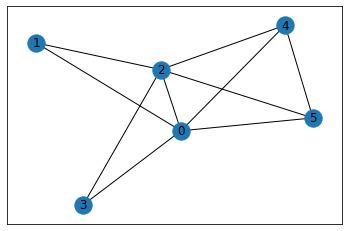

In [54]:
analyze_uv(g,0,2,draw_method=nx.draw_networkx)

In [127]:
walks = generate_walk_count(g, 30, v=e_(g.shape[0],0), w=e_(g.shape[0],0))
print(walks)
x=sp.symbols("x")
k=0
q = sum([walks[i]*x**(k-i) for i in range(k+1)])
(g.charpoly(x=x)*q).as_expr().expand()

[1, 0, 3, 4, 16, 34, 103, 250, 698, 1778, 4811, 12504, 33384, 87538, 232331, 611630, 1618978, 4269722, 11288319, 29794692, 78728608, 207874306, 549146015, 1450199554, 3830598106, 10116701250, 26721200195, 70573709232, 186401812744, 492315756210, 1300308710307]


x**5 - 6*x**3 - 4*x**2 + 3*x + 2

In [78]:
poly = 0*x**0
n = g.shape[0]
for u in range(g.shape[0]):
    for v in range(g.shape[0]):
        w = generate_walk_count(g, 10, v=e_(n, u), w=e_(n, v))[n+1]
        poly += w*residual(g, g.charpoly(x=x), x=x, v=e_(n, u), w=e_(n, v))
            
pretty_poly_print(poly)

<IPython.core.display.Math object>

In [159]:
cp = g.charpoly(x=x).as_expr()
(x*cp.diff()-g.shape[0]*cp).factor()

2*(7*x**3 + 9*x**2 - 6*x - 5)